# Introduction to DSC (Part I)

DSC (Dynamic Statistical Comparisons) provides a framework for managing computational benchmarking
experiments that compare several competing statistical methods
for a task across datasets or simulation scenarios. 
DSC helps execute such comparisons in an organized and reproducible
way, and provides convenient ways to query the results.
DSC is designed to help make these comparisons
"dynamic" -- that is, easy to extend by adding new methods or simulation scenarios. Hence the name: "Dynamic Statistical Comparisons".

DSC is particularly well suited to experiments run using the R or Python environments, and also provides some support for experiments that mix these two environments.

## Overview

Suppose we want to compare several methods for a particular inference task, $I$ say. For example, $I$ could be "predict the missing entries in a matrix with missing entries", "estimate a covariance matrix from a sample", or "estimate a regression function relating outcome $Y$ to covariates (features) $X$".

To compare methods to perform $I$ we could conduct a benchmarking experiment, by repeating the following three steps:

  1. Simulate some data suitable for performing $I$.
  2. Analyze the data with a method designed to perform $I$.
  3. Score how well the method performed $I$ (e.g. by comparison with the simulation ground truth).

DSC can handle more complex
settings than this, but this basic structure suffices to explain the key concepts. We will call this the `simulate`-`analyze`-`score` structure.

### Modules, groups, and pipelines

Typically we will want to consider multiple ways
to perform each of the steps 1-3: multiple ways to simulate data, multiple ways to analyze the data, and multiple ways to score
how well a method performed. 
In DSC this is accomplished by defining groups of
"modules" that can accomplish each step. For example, we would define a group of `simulate` modules, each of which can perform step 1; a group of
`analyze` modules, each of which can perform step 2; and a group of `score` modules, each of which can perform step 3. Running the benchmark then consists of running lots of "pipelines"
-- sequences of modules -- each of which involves running one module from the `simulate` group, followed by one module from the `analyze` group, followed by one module from the `score` group. 

DSC helps manage and run benchmarks like these, as well as more complex ones. The modular design 
makes it easy to extend
benchmarks (e.g. adding a new method simply by defining a new `analyze` module). And DSC helps with parallelization: for example, once a `simulate` module has created a dataset, DSC can apply multiple `analyze` modules in parallel on a suitable compute cluster. 


### Running benchmarks with DSC

To run a benchmark using DSC the user must:

1. Create a "DSC file" which specifies all the necessary modules, groups, and pipelines, and how information flows from module to module. The DSC file is a text file written using a custom-built syntax illustrated below (and explained in more detail in [Part II of the Introduction](First_Course_Elaborated.html)). 

2. Run the DSC using the `dsc` command line program. This runs all pipelines specified by the DSC file, and saves results to files in a structured way that makes them easy to query.

3. Query and summarize the results. The simplest way to do this is using the R package `dscrutils`, which provides a convenient way to read results from the DSC into an R dataframe, as illustrated below.

## Example

We now illustrate DSC using a simple example benchmark. 

Our example benchmark compares methods
for a very simple task: estimating the mean of a population given a random sample from the population. We will compare two methods for estimating the population mean: the sample mean and the sample median. We will simulate under two different population distributions: a *t* distribution and a normal distribution. And we will compute accuracy using two different metrics: squared error, and absolute error. 

### The DSC file

We implement this DSC in [R](https://cran.r-project.org/). Material used, including the DSC file, 
can be found in the [DSC2 vignettes repo](https://github.com/stephenslab/dsc2/tree/master/vignettes/one_sample_location). We defer a detailed explanation of the syntax of the DSC file to Part II. For now we just show it with minimal explanation:

```
normal: normal.R
  n: 100
  $data: x
  $true_mean: 0

t: t.R
  n: 100
  df: 2
  $data: x
  $true_mean: 3

mean: mean.R
  x: $data
  $est_mean: y

median: median.R
  x: $data
  $est_mean: y

sq_err: sq.R
  a: $est_mean
  b: $true_mean
  $error: e
 
abs_err: abs.R
  a: $est_mean
  b: $true_mean
  $error: e 
  
DSC:
    define:
      simulate: normal, t
      analyze: mean, median
      score: abs_err, sq_err
    run: simulate * analyze * score
    exec_path: R
    output: dsc_result
```

This DSC file defines six modules: two `simulate` modules  (`normal`, `t`), two `analyze` modules (`mean`, `median`), and two `score` modules (`sq_err`,`abs_err`). It then defines module groups (`simulate`,`analyze` and `score`), and the pipelines to run.

The modules all involve very simple `R` scripts in the `R/` subdirectory:

```r
==> normal.R <==
x = rnorm(n,0,1)

==> t.R <==
x = 3+rt(n,df)

==> mean.R <==
y = mean(x)

==> median.R <==
y = median(x)

==> sq.R <==
e = (a-b)^2

==> abs.R <==
e = abs(a-b)  
```

### Run DSC 

In [1]:
%cd ~/GIT/dsc2/vignettes/one_sample_location

/home/gaow/GIT/dsc2/vignettes/one_sample_location

We run 10 replicates of this benchmark (each replicate using a different random number seed), using 8 CPU threads:

In [2]:
! dsc settings.dsc --replicate 10 -c 8

INFO: Checking R library dscrutils@stephenslab/dsc2/dscrutils ...
INFO: DSC script exported to dsc_result.html
INFO: Constructing DSC from settings.dsc ...
INFO: Building execution graph & running DSC ...
DSC: 100%|██████████████████████████████████████| 15/15 [00:17<00:00,  1.15s/it]
INFO: Building DSC database ...
INFO: DSC complete!
INFO: Elapsed time 21.323 seconds.


(For first time users of DSC with `R`, a companion `R` package `dscrutils` will be automatically installed at this point.)

When run, DSC will create results files in the folder `dsc_result/` (as specified in the DSC file). We will see how to query these results and read them into `R` below.

In addition, DSC will create an html file [`dsc_result.html`](dsc_result.html) in the working directory. This file allows you to conveniently view the DSC file, executed pipelines and their source code.

 

### Query and visualize results

We use the R function `dscquery` in the `dscrutils` package to extract results. Since this example is small it is simple to load all results into an R dataframe and explore from there. In more complex examples one might want to start by extracting subsets of results; see `?dscquery` for more information.

In [1]:
dsc_dir = "dsc_result"
res = dscrutils::dscquery(dsc_dir, targets="simulate analyze score.error")

Failed to switch to language "ir": No subkernel named ir is found. Please make sure that you have the kernel installed (listed in the output of "jupyter kernelspec list" and usable in jupyter by itself), install appropriate language module (e.g. "pip install sos-r"), restart jupyter notebook and try again.


In [4]:
head(res)

simulate,simulate.output.file,analyze,analyze.output.file,score,score.error
normal,normal_1,mean,normal_1_mean_1,abs_err,0.008612093
normal,normal_2,mean,normal_2_mean_1,abs_err,0.135861196
normal,normal_3,mean,normal_3_mean_1,abs_err,0.090451192
normal,normal_4,mean,normal_4_mean_1,abs_err,0.015155347
normal,normal_5,mean,normal_5_mean_1,abs_err,0.010584144
normal,normal_6,mean,normal_6_mean_1,abs_err,0.060150705


Once the results are in a dataframe in R like this we can easily use standard R functions to investigate them further.

For example, we can summarize results using the `aggregate` function:

In [5]:
aggregate(score.error ~ analyze + simulate + score, res, mean)

analyze,simulate,score,score.error
mean,normal,abs_err,0.060839483
median,normal,abs_err,0.082331086
mean,t,abs_err,0.171557059
median,t,abs_err,0.097701046
mean,normal,sq_err,0.005586145
median,normal,sq_err,0.011788340
mean,t,sq_err,0.050010866
median,t,sq_err,0.014035104


Here we summarize results of the *t* simulation, under the squared error metric:

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


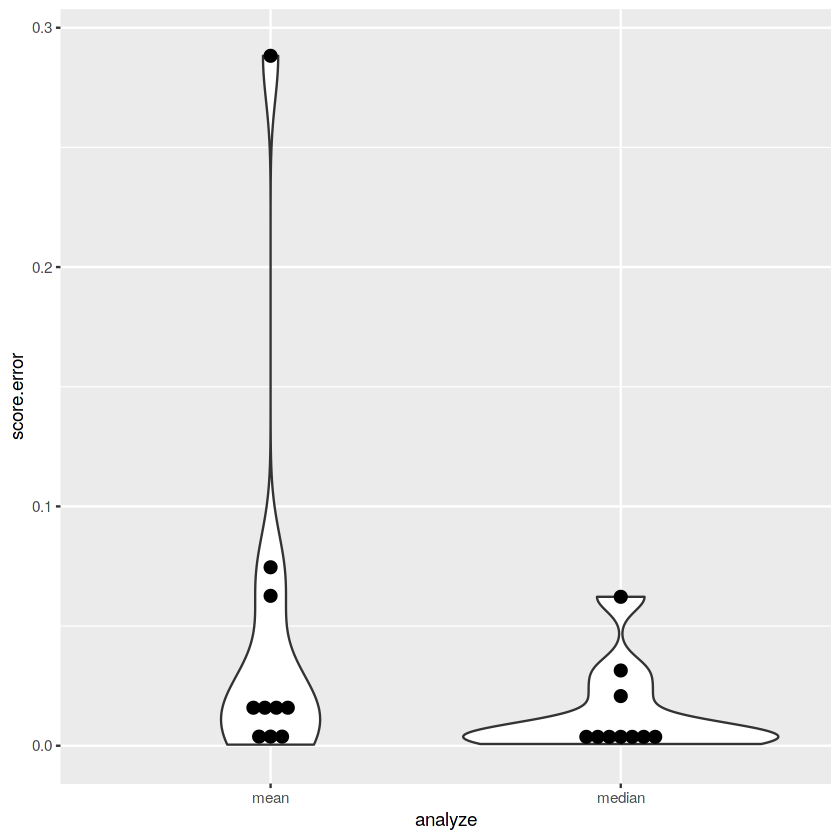

In [6]:
library(ggplot2)
p <- ggplot(data.frame(subset(res, simulate=="t" & score=='sq_err')[,c('analyze','score.error')]), 
            aes(x=analyze, y=score.error)) + 
    geom_violin() +
    geom_dotplot(binaxis='y', stackdir='center', dotsize = .5)
p